# Analyzing apps on the Apple's App Store

In this Notebook we will gather information about mobile applications from Apple's App Store by analyzing a Kaggle dataset.

The need for new mobile applications may have stagnated in recent times. However, many companies and single developers still rely on income through apps and keep developing them, be it by improving and maintaining existing apps or creating new ones in the hopes that they will catch on and produce revenue. A large amount of apps are already on the market and it is difficult to compete with them, so creating high quality user experiences and app store presences is of the utmost importance. Unfortunately, most developers have limited resources and may only focus their time and money on carefully selected products or features. We will try to create some insight into what it takes to create a successful app.

## Loading the dataset
Let us start by loading the Kaggle dataset. On Kaggle's implementation of Jupyter Notebook, this is very simple.

In [1]:
import pandas as pd

data = pd.read_csv('/kaggle/input/app-store-apple-data-set-10k-apps/AppleStore.csv')
data.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


## Creating a metric

We do not want to rely solely on user ratings or app downloads to meassure the success of our app. An app with only a few downloads might still receive a 5 star rating. Similarly, a bad app might still get a lot of downloads, for example by baiting the users with good advertising or by scamming. In order to mitigate the downsides of both individual metrics, we will try to combine them into a new metric called "score" by multiplying the rating with the number of downloads. Unfortunately, the dataset does not contain information about the number of downloads. It does however report on the number of ratings for each app. We will use this as a substitute. The underlying assumption is that there is a linear correlation between the download and rating counts, which may not be accurate. Also note that we are treating the ratings as if they were ratio values, even though they are just ordinals.

In [18]:
scores = data['user_rating'] * data['rating_count_tot']
data['score'] = scores

# Show the apps that are ranked highest.
data.sort_values(by='score', ascending=False).head()[['track_name', 'score']]

,track_name,score
16,Facebook,10411366.0
519,Instagram,9727011.0
1346,Clash of Clans,9588622.5
707,Temple Run,7760457.0
755,Pinterest,4777308.0


We can see that the metric ranks very popular apps such as Facebook and Instagram highly, so we will conclude that this is a useful meassurement of each app's success.
Plotting the distribution of scores shows that most apps have a score that is relatively close to zero:

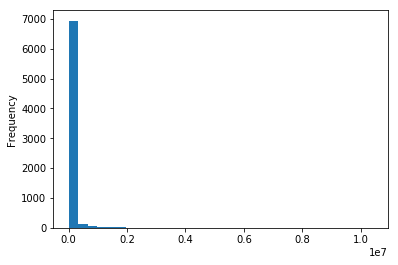

In [3]:
data['score'].plot.hist(bins=32)
pass

## Genres

We will now compare how different genres with our metric.
First, here is the distribution of genres:

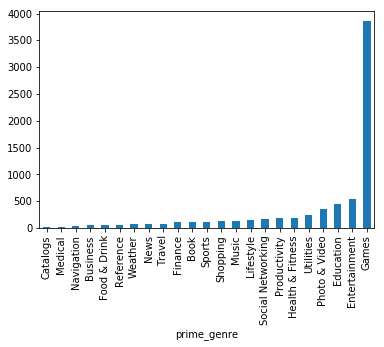

In [20]:
data.groupby('prime_genre')['id'].count().sort_values().plot.bar()
pass

The dataset includes almost 4000 apps whose primary genre is "Games". It is also by far the most common one, followed by a similar genre: "Entertainment".
Let's compare genres by their average score:

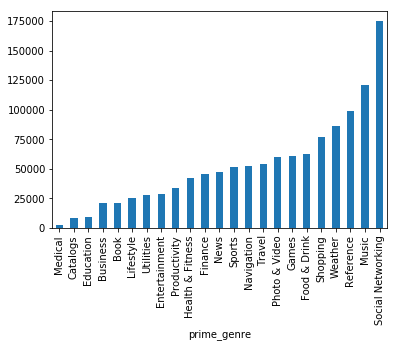

In [5]:
means = data.groupby('prime_genre').mean().sort_values('score')
means['score'].plot.bar()
pass

The data shows that social network apps are by far the most popular. Medical apps on the other hand have a very low average score. This may seem like creating creating a social networking app is the best approach, but of course, the market may be saturated and perhaps a desirable medical app is a better candidate.

Looking at the mean of each genre's scores can be deceiving, because it is heavily influenced by outliers. So it makes sense that social networking apps have a high mean, because there are very popular apps, but the sparsity of such apps is not well reflected. To see what score an app would get in each genre if it were just above the 50th percentile, we can instead look at the medians:

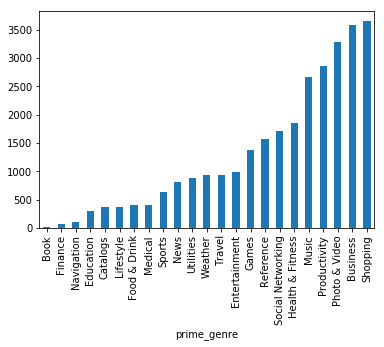

In [6]:
medians = data.groupby('prime_genre').median().sort_values('score')
medians['score'].plot.bar()
pass

The chart suggests that "Shopping", "Business" and "Photo & Video" apps are good candidates to achieve a decent amount of success.

## App sizes

The size of an app undoubtetly plays a role in customer satisfaction. Be it due to memory constraints or a limited internet connection, a smaller app is always preferable. The following scatter plot shows how an app's size correlates with its success:

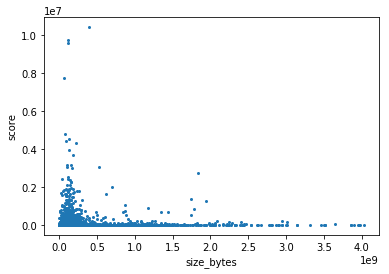

In [40]:
data.plot.scatter('size_bytes', 'score', s=4)
pass

Clearly, most successful apps are below 300MB in size. That is not to say that a larger app cannot be successful: Some apps that are almost as big as 2GB achieved moderate popularity. Regardless, an app developer should try to keep the app's size below 300MB if possible. Optimizations below, say, 100MB, may however be unnecessary and a waste of resources.

## Supported devices

The histogram below shows the distribution of the number of supported devices. Most apps support between 35 and 45 different devices.

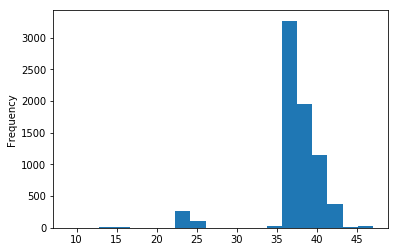

In [57]:
data['sup_devices.num'].plot.hist(bins=20)
pass

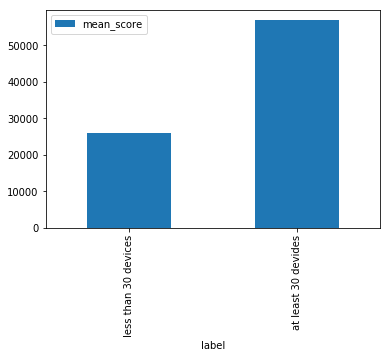

In [61]:
less = data[data['sup_devices.num'] < 30]
more = data[data['sup_devices.num'] >= 30]
frame = pd.DataFrame([
    ('less than 30 devices', less['score'].mean()),
    ('at least 30 devides', more['score'].mean())
], columns=('label', 'mean_score'))
frame.plot.bar(x='label')
pass

The bar chart above shows that apps which support at least 30 devices are on average twice as successful as those which support less than 30.

## Supported languages

The following graph shows that apps which support at least 30 languages are on average three times as successful as apps which do not.

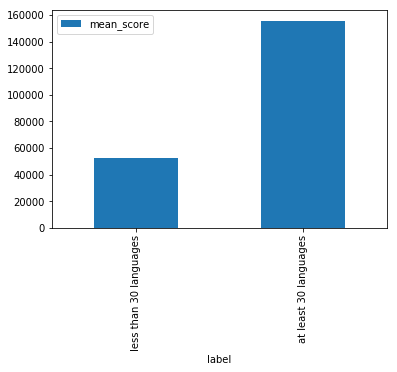

In [82]:
less = data[data['lang.num'] < 30]
more = data[data['lang.num'] >= 30]
frame = pd.DataFrame([
    ('less than 30 languages', less['score'].mean()),
    ('at least 30 languages', more['score'].mean())
], columns=('label', 'mean_score'))
frame.plot.bar(x='label')
pass

## How to improve existing apps

In this section we will try to determine the best way to further improve an existing app. That is, should development time be spent on supporting additional languages, additional devices, decreasing the size of the app, or perhaps making the app more affordable. In order to do so, we will test how much each of these meassures linearly correlates with the score through Pearson's correlation coefficient.

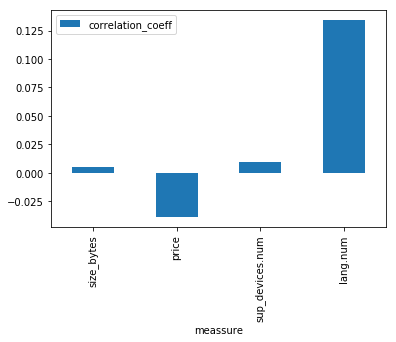

In [55]:
columns = ['size_bytes', 'price', 'sup_devices.num', 'lang.num']
correlations = []
scores = data['score']
scores_mean = scores.mean()
scores_std = scores.std()
for column_name in columns:
    column = data[column_name]
    coeff = ((column - column.mean()) * (scores - scores_mean)).mean() / (column.std() * scores_std)
    correlations.append((column_name, coeff))

correlations = pd.DataFrame(correlations, columns=['meassure', 'correlation_coeff'])
correlations.plot.bar(x='meassure')
pass

As we can see, the number of supported languages has the highest correlation with the score, meaning this should be a focus for developers. The price also negatively correlates with the score, so reducing the price can also lead to more success (as expected). The predictive ability of the number of supported devices is not as high, likely because most apps already support a solid amount of devices. Interestingly the size of the app is slightly positively correlated with its success. A good explanation for this is that very small apps also do not offer a lot of content and are therefore unlikely to be popular.